# Insights into Magnetic Resonance Imaging

## Simulation of a Spin Ensemble and a Spin Echo Experiment

First we import the required libraries.

In [1]:
import sys
import numpy as np
import cmath
import math
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9) #if your plots turn out too large or small, adjust this

We remember how we can use matplotlib to plot a graph into our Jupyter Notebook.
Here an example on how to plot a linear graph supported by 4 points.
Remember that the index in Python starts with zero.

**NOTICE:** If the plot you are just going to generate is too large or small, adjust the line `plt.rcParams["figure.figsize"]` above with different numbers and re-run.

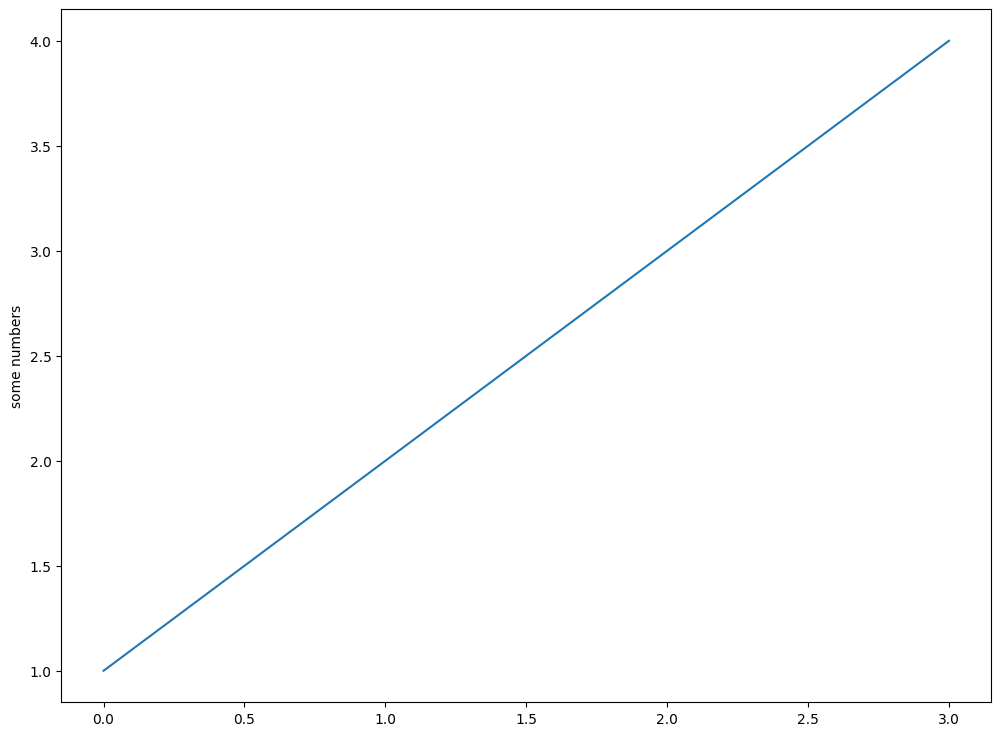

In [2]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

## The Vector Class

Some linear algebra is required. Here, we provide functionality for three-dimensional vectors.
It is possible to rotate the vectors around the x-axis and z-axis.

- Rotation around the z-axis
This is used to represent precession. Any vector that is tiltet against the z-axis will precess at the Larmor frequency.
So this is happening without any radiofrequency pulses being applied.

- Rotation around the x-axis
This is simulating a radiofrequency (RF)-pulse applied along the x-axis. Using such a pulse, the magnetization can be modified. For a system in equilibrium, the entire z-magnetization is aligned along the z-axis. So, a RF pulse can be used to bring the magnetization out of equilibrium.

In [3]:
class Vector:
    def __init__(self, x, y, z):
        self.value = np.array([x,y,z])
        self.precision_digits=8
    def rotatez(self, angle):
        rotmatz = np.array([[    math.cos(angle), -math.sin(angle), 0.0],
                                [math.sin(angle), math.cos(angle), 0.0],
                                [0.0, 0.0, 1.0]
                        ])
        self.value = np.dot(rotmatz, self.value)
        return self
    def rotatex(self, angle):
        rotmatz = np.array([   [1.0, 0.0, 0.0],
                            [  0.0, math.cos(angle), -math.sin(angle)],
                                [0.0, math.sin(angle), math.cos(angle)],
                                
                        ])
        self.value = np.dot(rotmatz, self.value)
        return self    
    def print(self):
        print(self.toString())
    def toString(self):
        return f"({self.value[0]}, {self.value[1]}, {self.value[2]})"
    def mult(self, factor):
        self.value = self.value * factor
        return self
    def add(self, summand):
        self.value = self.value + summand.value
        return self   
    def norm(self):
        return np.linalg.norm(self.value) 
    def round(self):
        self.value = np.around(self.value, decimals=self.precision_digits) 
        return self
    def projectxy(self):
        return Vector(self.value[0], self.value[1], 0.0)

### Let's try out the Vector Class:

We can instantiate a **Vector Object** by using the constructor:

`v = Vector(0,0,1)` creates one Vector with x,y,z = (0,0,1)

If we rotate this vector around the x-axis, the vector length does not change.
Vector length is the **vector norm**

You see that the vector norm does not change no matter by which amount you rotate the vector around the x- or z-axes.

In [4]:
v = Vector(0,0,1)
print(f"Freshly instantiated vector object {v.toString()}")
print(f"Vector norm is {v.norm()}")

v.rotatex(np.deg2rad(45)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

v.rotatez(np.deg2rad(45)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

v.rotatez(np.deg2rad(135)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

v.rotatex(np.deg2rad(135)).round()
print(f"Vector after rotation {v.toString()}")
print(f"Vector norm is {round(v.norm(), ndigits = 8)}")

Freshly instantiated vector object (0, 0, 1)
Vector norm is 1.0
Vector after rotation (0.0, -0.70710678, 0.70710678)
Vector norm is 1.0
Vector after rotation (0.5, -0.5, 0.70710678)
Vector norm is 1.0
Vector after rotation (0.0, 0.70710678, 0.70710678)
Vector norm is 1.0
Vector after rotation (0.0, -1.0, 0.0)
Vector norm is 1.0


There is a little trick involved here, to make the output look better.
There are rounding errors in any computation using floating point numbers. 
Floating point numbers are the way the computer represents the decimal digits of numbers. As there is only limited space and specifically in trigonometric functions like sine and cosine infinite decimals occur, rounding errors must occur.
For this example, we repeatedly call the `round` function of the class, to remove the small rounding errors.

## Exercise:
Change the rotation angles above and the vector itself and observe the effects.
You may add more rotations or simplify to less rotations.
Try negative rotations.
Use a real world object like a pen and paper drawings to understand the way the rotations work.

## Exercise:
Try out other functions of the vector class, such as `projectxy`, which gives the vector projected onto the x/y-plane.

## The Spin Class

We will now utilize the *Vector Class* to implement a **Spin Class**.
This class will represent some properties of a small **spin**. A spin is the smallest component of the MRI experiment that we are simulating. Everything we do in the next steps will result in changes to the spin objects. Every single spin object holds a specific state of a spin that it represents. By later using many spin objects at once, we can manipulate them in different ways and store the information in a large set of many spin objects.

But before we do that, we need to define what one single spin needs to know about itself:

* It should know the precession frequency. While in the big perspective, all spins precess about at the **Larmor Frequency**, which is approximately **64 MHz at 1.5 Tesla**, there are frequency shifts that individual spins experience that lower or increase the local Larmor Frequency by a few **parts per million (ppm)**. Such small frequency shifts can be deliberate, e.g. by applying external gradient fields, but thay can also be a property of the matter itself, e.g. caused by susceptibility differences between different tissue components. So, each spin stores its current precession frequency in a class variable called `frequency`. Recall that class variables are referenced by adding the `self` object, e.g. `self.frequency` refers to the class variable `frequency` of the current object.

* It knows its magnitude. That is the vector norm. Note that when the object is instantiated in the `__init__` function. A unit vector, i.e. a vector of magnitude one, is created along the z-axis and multiplied by the magnitude, resulting in a vector of the desired magnitude.

### Exercise:
Experiment with the vector norm function in the previous example (where you rotated vectors), by instantiating unit vectors, multiplying them and checking the resulting norm and the stability of this norm under rotation.


In [5]:
# Use this space to experiment, you may want to copy some code from above


* It also holds information about its Vector Object. In a sense, a Spin Object is mainly a Vector Object, but it allows some operations that are not basic Vector operations but specific to Spins.

* It provides several functions that make sense to be applied to a Spin Object:

    * Precession: Precession is what happens to a spin in a magnetic field automatically over time. 

    ### Exercise:
    Read through the `precess(self, time_msec)` function and try to understand what it does.
    <details>
        <summary>Answer</summary>
        It divides the time given in milliseconds by 1000, to obtain the time in seconds.
        It then calculates the radians of a full rotation of 2*pi and multiplies that by the previous result.
        This gives the amount of rotation in radians that occurs in one second if the frequency is 1 Hertz.
        We then multiply by `self.frequency` to obtain the rotations at this frequency.
    </details>

* It also provides a possibility to be rotated around the x-axis. Here, the angle in radians is provided as an argument directly.

In [6]:
class Spin:
    def __init__(self, frequency, magnitude):
        self.frequency = frequency
        self.magnitude = magnitude
        self.vector = Vector(0.0, 0.0, 1.0).mult(magnitude);
    def getFrequency(self):
        return self.frequency
    def precess(self, time_msec):
        angle = ((time_msec/1000)*2.0*math.pi)*self.frequency
        #print(f"angle = {angle}")
        self.vector = self.vector.rotatez(angle)
    def print(self):
        print(f"Frequency = {self.frequency}, vector = {self.vector.toString()}, magnitude = {self.magnitude}")
    def magnitude(self):
        return np.norm(self.vector.projectxy())    
    def reset(self):
        self.vector = Vector(0.0, 0.0, self.vector.norm())  
    def rotatex(self, angle):
        self.vector = self.vector.rotatex(angle)

## The Spin Ensemble Class

This class now collects many spins into one unit called a **spin ensemble**.
A *spin ensemble* is thus a collection of many spins. How many can be provided to the constructor as an argument `number_spins`.

The constructor also takes the arguments `offset_frequency` and `stdev_offset`, which are used to generate a Gaussian distribution of Spin frequencies within the ensemble with mean and standard deviation according to these parameters.

The result is a collection of many Spin Objects, all with different frequencies.

One can calculate a magnitude for the entire ensemble, which is the vector sum of all spins in the ensemble.

### Exercise:
Read through the following Class definition and try to understand what the Class Functions do, and why they may be needed.

In [7]:
class Spinensemble:
    
    def __init__(self, number_spins, offset_frequency, stdev_offset):
        magnitude = 2.0
        self.spin_array = [ Spin(freq, magnitude) for freq in np.random.normal(offset_frequency, stdev_offset, number_spins)]
    def precess(self, time_msec):
        for spin in self.spin_array:
            spin.precess(time_msec)
    def magnitude(self):
        res = Vector(0.0,0.0,0.0)
        for spin in self.spin_array:
            res=res.add(spin.vector)
        return res.norm()
    def magnitudeAfterPrecession(self,time_msec):     
        self.precess(time_msec)      
        return self.magnitude
    def invert(self):
        for spin in self.spin_array:
            spin.frequency = -spin.frequency
    def phase_reset(self):
        for spin in self.spin_array:
            spin.reset()
    def x_pulse(self, angle_in_deg):
        for spin in self.spin_array:
            spin.rotatex(np.deg2rad(angle_in_deg))   

### Exercise:
Instantiate a Spinensemble Class Object and use the class functions to manipulate the magnetization, print your results and try to understand why the output changes in the way it does under these manipulations:

In [8]:
# Experiment here

<details>
<summary>Example Code and Some Useful Constants</summary>
The following code may be useful for you to experiment

Note that some reasonable values for a typical spin ensemble setup are provided in the section of constants at the top. E.g. a Larmor Frequency of 64 MHz, modeling a 1.5 Tesla MRI system.
   
```python
number_spins = 1000
larmor_frequency = 64.0e6 #Hz
offset_frequency = 4.7e-6 * larmor_frequency
stdev_offset = 0.2e-6 * larmor_frequency
stdev_larmor = 0.2e-6 #ppm

print(f"offset_frequency = {offset_frequency}, stdev_offset = {stdev_offset}")

# spin = Spin(offset_frequency+stdev_offset, 2.0)
# spin.print()
# spin.precess(1)
# spin.print()
# #1.0/larmor_frequency = 1.5625e-08

spins = Spinensemble(number_spins, offset_frequency, stdev_offset)

print(spins.magnitude())
spins.x_pulse(90)
spins.precess(10)
print(spins.magnitude())
```
</details>

## A Spin Echo Experiment on a Spin Ensemble

Now that you have experimented with the Classes **Vector**, **Spin** and **Spinensemble**, you might have the impression that it is far to go to simulate an MRI experiment to gain some interesting insights from.
However, the next code example shows that we can now utilize the mentioned classes to provide a spin echo experiment and follow the magnetization of the spin ensemble over time graphically.

### Interlude: 
Exploring functions as arguments in Python. 
You can skip to the next section, unless you are interested in the specifics of this.
This was a consideration when thinking about how to implement the following classes.
However, I decided not to use this

In [9]:
class a:
    def __init__(self, b):
        self.b=b
    def printb(self):
        print(f"{self.b}")

class c:
    def __init__(self, d):
        self.f = d.printb
    def callf(self):
        self.f()

ia = a(3)
#ia.printb()

ic = c(ia)
ic.callf()


3


In [10]:
class Pulse:
    def __init__(self, type, time, value):
        self.time = time
        self.value = value
        self.type = type
        if self.type == 'x-pulse':
            self.color="m"
        elif self.type == 'invert':
            self.color="g"   
    def apply(self, ensemble):
        print(f"applying {self.toString()}")
        if self.type == 'x-pulse':
            ensemble.x_pulse(self.value)
        elif self.type == 'invert':
            ensemble.invert()
    def toString(self):
        if self.value:
            return f"{self.type}({self.time}, {self.value})"
        else:
            return f"{self.type}({self.time})"
    def expectedPeaks(self, peaks): #peak is [time, absolute height, relative height]
        expected = []
        for peak in peaks:
            TE_half = self.time - peak[0]
            # TE = 2 * TE_half
            absolute_time_of_echo = self.time + TE_half
            # absolute_time_of_echo = peak[0] + TE #gives same value
            expected.append([absolute_time_of_echo, None, None, self.toString() + "(" + peak[3] + ")"]) # cannot determine signal as not necessarily available yet
        return expected

**continue here**

### The Pulse Sequence Class
This class keeps all the information about the pulse sequence, the magnetization over time and the resulting peaks.
For the basic functionality, it could be much shorter, however it includes a substantial amount of extra code to identify and predict the peaks, such that the resulting diagrams are easier to read.

The core functionality is this:

```python
def simulate(self, ensemble, timepoints):
for i in tqdm(timepoints[1:]):
    elapsed = i - prev_timepoint
    ensemble.precess(elapsed)
    timepoints_passed = [*range(prev_timepoint+1, i+1)]
    self.checkPulseAndApplyIfAppropriate(ensemble, timepoints_passed)
    mag = ensemble.magnitude()
    self.signal_over_time.append(mag)
    prev_timepoint = i
    self.sortExpectedPeaks()
return [timepoints, self.signal_over_time, self.peaks]
```

This code basically checks if a pulse should be applied within the current time step, executes the pulse infinitely fast (a simplification of the true physical situation, however pulses can be considered very fast compared to spin evolution as a first approximation).
It then allows evolution of the magnetization (without relaxation at the current time).

In [11]:
class PulseSequence:
    def __init__(self):
        self.sequence = []
        self.expected_peaks = []
        self.peaks = []
        self.timepoints = None
        self.ensemble = None
        self.signal_over_time = []
    def add(self, pulse):
        self.sequence.append(pulse)
    def simulate(self, ensemble, timepoints):
        current_peak_label_asc = ord('A')
        self.timepoints = timepoints
        self.ensemble = ensemble
        ensemble.phase_reset()
        self.signal_over_time = []
        self.peaks = []
        self.expected_peaks = []
        prev_timepoint = timepoints[0]
        self.signal_over_time.append(ensemble.magnitude())
        last_min = 0
        detect_thresh = 150
        cur_max = [None, 0, None]
        for i in tqdm(timepoints[1:]):
            elapsed = i - prev_timepoint
            ensemble.precess(elapsed)
            timepoints_passed = [*range(prev_timepoint+1, i+1)]
            self.checkPulseAndApplyIfAppropriate(ensemble, timepoints_passed)
            #print(f"{timepoints_passed=}")
            mag = ensemble.magnitude()
            self.signal_over_time.append(mag)
            if mag < last_min:
                last_min = mag
            if (mag - last_min > detect_thresh):
                if mag >= cur_max[1]:
                    cur_max = [i, mag, mag-last_min, chr(current_peak_label_asc)]
            if cur_max[0]:
                if (cur_max[1] - mag > detect_thresh):
                    self.peaks.append(cur_max)
                    cur_max=[None, 0, None]
                    last_min = mag
                    current_peak_label_asc+=1
            prev_timepoint = i
            self.sortExpectedPeaks()
        return [timepoints, self.signal_over_time, self.peaks]
    def checkPulseAndApplyIfAppropriate(self, ensemble, timepoints):
        for pulse in self.sequence:
            if pulse.time in timepoints:
                print(f"{pulse.time=}, {timepoints=}")
                #print(f"checking {pulse.toString()}")
                pulse.apply(ensemble)
                self.expected_peaks = self.expected_peaks + pulse.expectedPeaks(self.peaks)
    def plotWithSignal(self, signal):
        for pulse in self.sequence:
            label = f"{pulse.toString()}"
            plt.axvline(x = pulse.time, color = pulse.color, label = label)
            plt.text(pulse.time, max(signal[1])*.8, label,rotation=90)
        plt.plot(signal[0], signal[1], color = 'b')
    def sortExpectedPeaks(self):
        self.expected_peaks = sorted(self.expected_peaks, key=lambda x: x[0])
    def determineHeightOfExpectedPeaks(self):
        prev_timepoint = self.timepoints[0]
        for i, j in zip(self.timepoints[1:], range(1,len(self.timepoints))):
            elapsed = i - prev_timepoint
            timepoints_passed = [*range(prev_timepoint+1, i+1)]  
            for k,l in zip(self.expected_peaks, range(0, len(self.expected_peaks))):
                #print(f"{k=}")
                if k[0] in timepoints_passed:
                    print(f"{k[0]} {j=} {self.signal_over_time[j]} {timepoints_passed=}")
                    cur_mag = self.signal_over_time[j]
                    self.expected_peaks[l][1] = cur_mag
            prev_timepoint = i
    def showExpectedPeaks(self):
        circle_radius = 5
        ydist = 50
        for p in self.expected_peaks:
            # circle = plt.Circle((p[0], p[1]), circle_radius, color = 'r')
            # plt.gca().add_patch(circle)
            plt.plot(p[0], p[1],'ro') 
            label = p[3]
            plt.text(p[0], p[1] + ydist, label,rotation=90)
    def showPeakLabels(self):
        circle_radius = 5
        ydist = 50
        xdist = 20
        for p in self.peaks:
            plt.plot(p[0], p[1],'go', markersize=10) 
            label = p[3]
            plt.text(p[0]-xdist, p[1] + ydist, label,rotation=0, fontsize=12)        

            




## Setting up the simulations

We are going to simulate at 1.5 Tesla, and we choose a few parameters that reflect the physical environment somewhat reasonably.

In [12]:
larmor_frequency = 64.0e6 #Hz
offset_frequency = 4.7e-6 * larmor_frequency
stdev_offset = 0.3e-6 * larmor_frequency
stdev_larmor = 0.2e-6 #ppm

NameError: name 'number_spins' is not defined

Now we define our simulation resolution.

###Exercise:
Play with these parameters. You need to re-run this code to make the changes effective.

In [ ]:
number_spins = 5000
timepoints = range(0,1000,2)
spins = Spinensemble(number_spins, offset_frequency, stdev_offset)

### Experiment 1:
One **Excitation Pulse** (90 degrees), followed by two **refocussing pulses** (180 degrees). 

The *Excitation Pulse* generates a **Free Induction Decay (FID)**, which is a phase-coherent magnetization that can be refocused by the following *refocusing pulses*.
Each refocusing pulse occurs to all previous peaks (phase coherences) at a distance of TE/2, such that the expected echo occurs at double that inverval (TE).
This means: to determine where an echo should occur, measure the distance from the current refocusing pulse to each peak to the left, and copy that distance to the right. That's where the echo should occur.

The code does this for you. It labels each peak with a letter and estimates all direct spin echos using the same approach as just described.

Pulses are shown as vertical lines, labeled by the pulse type, followed by the time the pulse is applied and its parameters (e.g. the flip angle for x-pulses).

Each estimated spin echo is  labeled by the pulse that invokes it, followed by the peak that is refocused in brackets.

This was you can identify better which peaks correspond to which pulses.

### Exercise:
Identify all pulses and echoes, try to understand them.
Play with the parameters.

  0%|          | 0/99 [00:00<?, ?it/s]

pulse.time=50, timepoints=[41, 42, 43, 44, 45, 46, 47, 48, 49, 50]

  8%|▊         | 8/99 [00:00<00:01, 77.67it/s]


applying x-pulse(50, 90)


 19%|█▉        | 19/99 [00:00<00:00, 92.68it/s]

pulse.time=100, timepoints=[91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
applying invert(100)


 29%|██▉       | 29/99 [00:00<00:00, 91.46it/s]

 39%|███▉      | 39/99 [00:00<00:00, 90.26it/s]

pulse.time=300, timepoints=[291, 292, 293, 294, 295, 296, 297, 298, 299, 300]
applying invert(300)


100%|██████████| 99/99 [00:01<00:00, 91.58it/s]


150 j=15 4000.0 timepoints_passed=[141, 142, 143, 144, 145, 146, 147, 148, 149, 150]
450 j=45 4000.0 timepoints_passed=[441, 442, 443, 444, 445, 446, 447, 448, 449, 450]
550 j=55 114.39492197465684 timepoints_passed=[541, 542, 543, 544, 545, 546, 547, 548, 549, 550]
[[150, 4000.0, None, 'invert(100)(A)'], [450, 4000.0, None, 'invert(300)(B)'], [550, 114.39492197465684, None, 'invert(300)(A)']]
[[50, 4000.0, 4000.0, 'A'], [150, 4000.0, 3952.6382359672625, 'B'], [450, 4000.0, 3984.557017947874, 'C'], [640, 178.65510183202284, 163.21211977989657, 'D']]


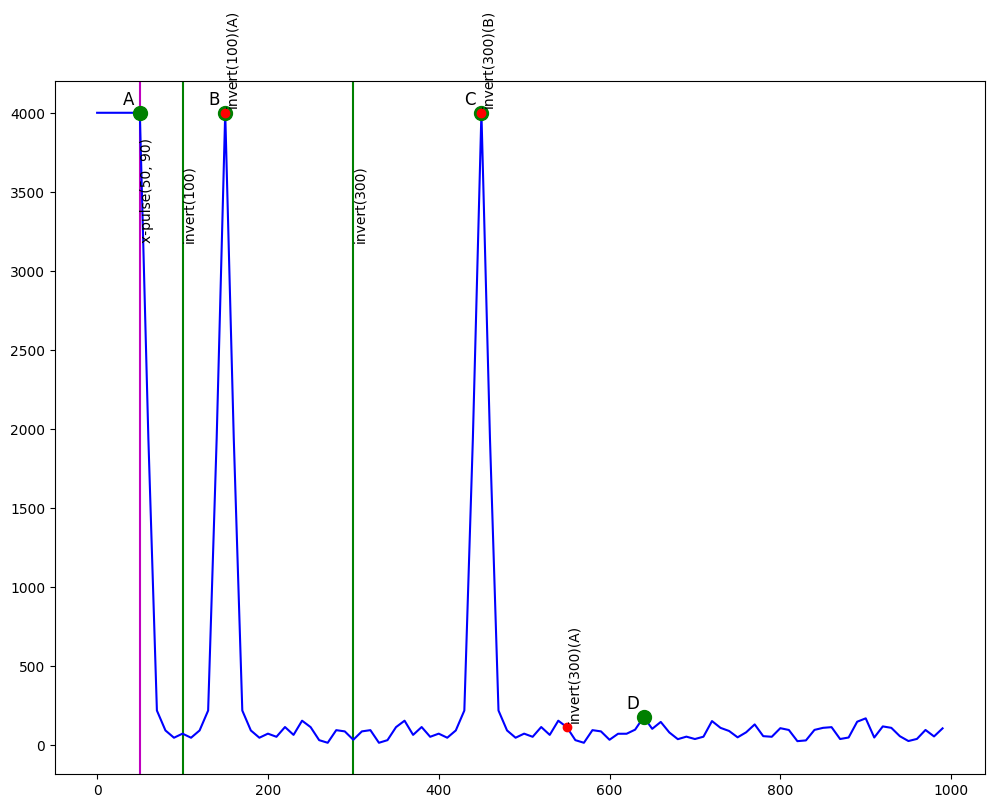

In [ ]:

pulseSequence = PulseSequence()
pulseSequence.add(Pulse("x-pulse", 50, 90))
pulseSequence.add(Pulse("invert", 100, None))
pulseSequence.add(Pulse("invert", 300, None))

signal_over_time = pulseSequence.simulate(spins, timepoints)
pulseSequence.plotWithSignal(signal_over_time)

pulseSequence.determineHeightOfExpectedPeaks()
print(pulseSequence.expected_peaks)
print(signal_over_time[2]) #peaks
pulseSequence.showPeakLabels()
pulseSequence.showExpectedPeaks()



### Experiment 2:
Now we move from pure refocusing pulses to pulses with less than 180 degree angle. Essentially, this approximates a **Hahn Spin-Echo** experiment, which would originally be done with 90 degree pulses throughout.

Using less than 90 degrees leaves some magnetization in the z-plane to be reused later.

### Exercise:
Play with the flip angles

Note that there are unlabeled pulses, these are **Stimulated Echoes**.

The mechanism for *stimulated echoes (STE)* is that magnetization is stored between two refocusing pulses, such that an echo occurs after the second pulse as if a pulse is refocused by the first pulse, had it and all its echoes been shifted to the time of the second pulse. 

### Exercise:
Identify stimulated echoes and understand them

  0%|          | 0/749 [00:00<?, ?it/s]

  4%|▍         | 32/749 [00:00<00:09, 78.96it/s] 

pulse.time=50, timepoints=[49, 50]
applying x-pulse(50, 70)


  8%|▊         | 59/749 [00:00<00:08, 83.32it/s]

pulse.time=100, timepoints=[99, 100]
applying x-pulse(100, 70)


 22%|██▏       | 162/749 [00:01<00:06, 87.93it/s]

pulse.time=300, timepoints=[299, 300]
applying x-pulse(300, 70)


100%|██████████| 749/749 [00:08<00:00, 85.90it/s]


150 j=75 1354.6462435480769 timepoints_passed=[149, 150]
450 j=225 536.4877601216032 timepoints_passed=[449, 450]
550 j=275 867.8880350380463 timepoints_passed=[549, 550]
[[150, 1354.6462435480769, None, 'x-pulse(100, 70)(A)'], [450, 536.4877601216032, None, 'x-pulse(300, 70)(B)'], [550, 867.8880350380463, None, 'x-pulse(300, 70)(A)']]
[[50, 4000.0000000001023, 4000.0000000001023, 'A'], [150, 1354.6462435480769, 931.8357683059164, 'B'], [350, 1601.6413571405703, 1418.0134619655362, 'C'], [448, 548.2656454229735, 378.26495685237273, 'D'], [502, 417.5366328225574, 246.94090070057933, 'E'], [550, 867.8880350380463, 685.2811254745485, 'F']]


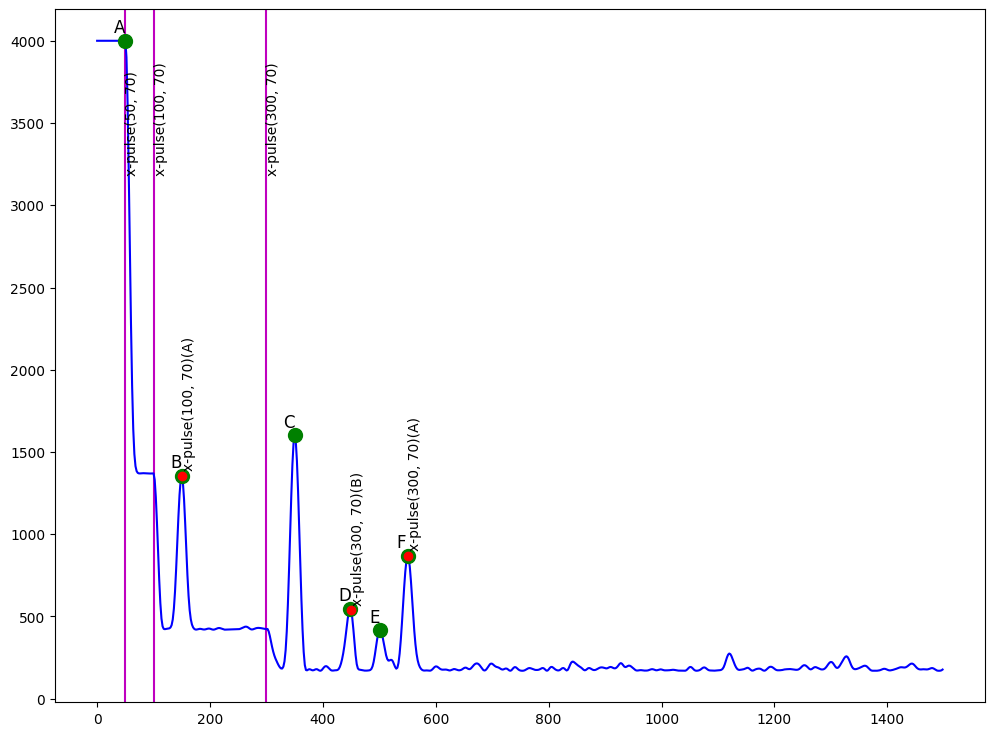

In [ ]:

pulseSequence = PulseSequence()
pulseSequence.add(Pulse("x-pulse", 50, 70))
pulseSequence.add(Pulse("x-pulse", 100, 70))
pulseSequence.add(Pulse("x-pulse", 300, 70))

signal_over_time = pulseSequence.simulate(spins, timepoints)
pulseSequence.plotWithSignal(signal_over_time)

pulseSequence.determineHeightOfExpectedPeaks()
print(pulseSequence.expected_peaks)
print(signal_over_time[2]) #peaks
pulseSequence.showPeakLabels()
pulseSequence.showExpectedPeaks()

### Experiment 3:
In this experiment we add one more pulse, which leads to the creation of a lot more echoes.

We need to extend our plot range a bit.

###Exercise:

Try to understand all the echoes. Play with the parameters.

  0%|          | 0/749 [00:00<?, ?it/s]

  6%|▌         | 44/749 [00:00<00:07, 89.39it/s] 

pulse.time=50, timepoints=[49, 50]
applying x-pulse(50, 80)


  9%|▊         | 65/749 [00:00<00:07, 94.23it/s]

pulse.time=100, timepoints=[99, 100]
applying x-pulse(100, 80)


 21%|██▏       | 160/749 [00:01<00:07, 80.48it/s]

pulse.time=300, timepoints=[299, 300]
applying x-pulse(300, 80)


 45%|████▍     | 335/749 [00:04<00:04, 86.58it/s]

pulse.time=640, timepoints=[639, 640]
applying x-pulse(640, 80)


100%|██████████| 749/749 [00:08<00:00, 85.56it/s] 


150 j=75 1682.5176931486335 timepoints_passed=[149, 150]
450 j=225 779.152769680485 timepoints_passed=[449, 450]
550 j=275 986.4154646793563 timepoints_passed=[549, 550]
730 j=365 372.2568431748064 timepoints_passed=[729, 730]
778 j=389 410.0366979136807 timepoints_passed=[777, 778]
832 j=416 569.4138140099463 timepoints_passed=[831, 832]
930 j=465 856.1454716238544 timepoints_passed=[929, 930]
1130 j=565 365.7086672115872 timepoints_passed=[1129, 1130]
1230 j=615 521.3932091101867 timepoints_passed=[1229, 1230]
[[150, 1682.5176931486335, None, 'x-pulse(100, 80)(A)'], [450, 779.152769680485, None, 'x-pulse(300, 80)(B)'], [550, 986.4154646793563, None, 'x-pulse(300, 80)(A)'], [730, 372.2568431748064, None, 'x-pulse(640, 80)(F)'], [778, 410.0366979136807, None, 'x-pulse(640, 80)(E)'], [832, 569.4138140099463, None, 'x-pulse(640, 80)(D)'], [930, 856.1454716238544, None, 'x-pulse(640, 80)(C)'], [1130, 365.7086672115872, None, 'x-pulse(640, 80)(B)'], [1230, 521.3932091101867, None, 'x-pulse

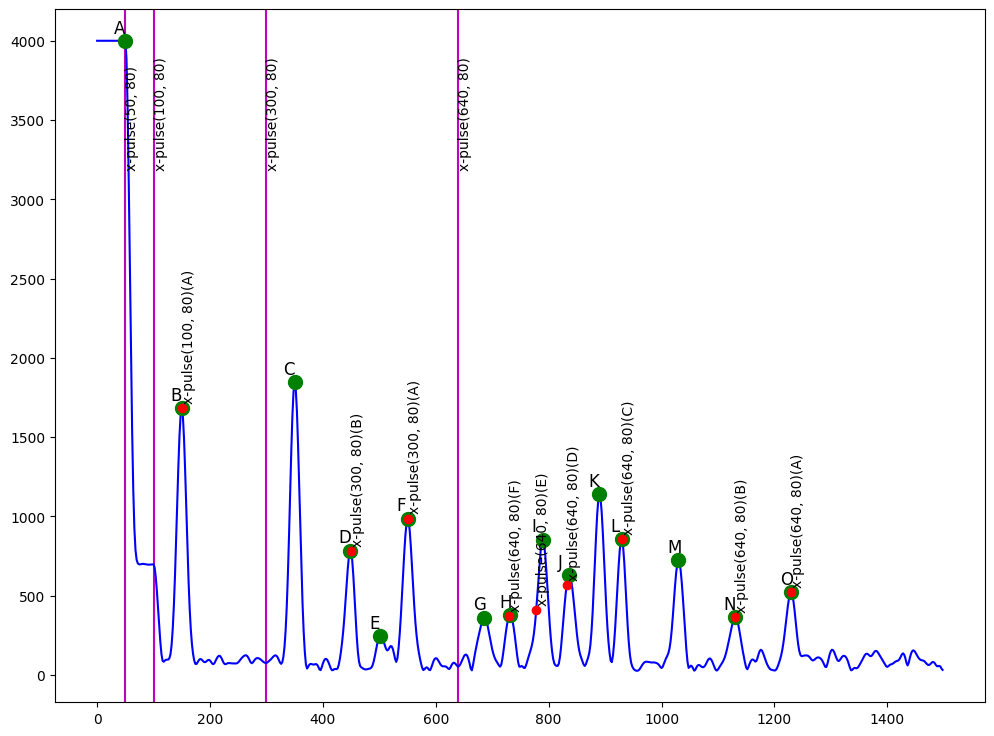

In [ ]:
number_spins = 5000
spins = Spinensemble(number_spins, offset_frequency, stdev_offset)

timepoints = range(0,1500,1)

pulseSequence = PulseSequence()
pulseSequence.add(Pulse("x-pulse", 50, 80))
pulseSequence.add(Pulse("x-pulse", 100, 80))
pulseSequence.add(Pulse("x-pulse", 300, 80))
pulseSequence.add(Pulse("x-pulse", 640, 80))

signal_over_time = pulseSequence.simulate(spins, timepoints)
pulseSequence.plotWithSignal(signal_over_time)

pulseSequence.determineHeightOfExpectedPeaks()
print(pulseSequence.expected_peaks)
print(signal_over_time[2]) #peaks
pulseSequence.showPeakLabels()
pulseSequence.showExpectedPeaks()

## Summary

Now you have simulated MRI spin-echo experiments using only basic python functions, thus gaining insights into mathematical/physical simulation in Python, while at the same time gaining insights into the inner workings of MRI experiments.

### Exercise:

Come up with completely new pulse sequences, below is space for your new code.

In [ ]:
# Write new pulse sequences here